In [1]:
import os
from omegaconf import OmegaConf
cfg = OmegaConf.load("../cfg.yaml")
print(cfg.path_rplan)
print(f"Path to RPLAN data exists: {os.path.exists(cfg.path_rplan)}")

/home/casper/Documents/Data/rplan/dataset/floorplan_dataset
Path to RPLAN data exists: True


In [50]:
import numpy as np
from rasterio import features
from shapely import geometry
from shapely.geometry import Polygon

from LayoutGKN.constants import CAT_RPLAN_ORIG, CAT_MAP

POLY_IMAGE = Polygon(((0, 0), (0, 256), (256, 256), (256, 0), (0, 0)))

def check_validity_polygon(poly):
    if poly == POLY_IMAGE: return False
    poly_mapped = geometry.mapping(poly)
    if len(poly_mapped) != 1:
        for subpoly in poly_mapped["coordinates"]:
            subpoly = Polygon(subpoly)
            if subpoly != POLY_IMAGE: return False
            else: return True


def extract_shapes_from_mask(mask, min_area=10):
    """Extracts all possible shapes from a binary mask."""

    shapes = features.shapes(mask, connectivity=4)
    polygons = []
    for s, _ in shapes:
        poly = Polygon(geometry.shape(s))
        if min_area < poly.area and check_validity_polygon(poly):
            polygons.append(poly)
    return polygons


def extract_rooms_from_image(img,
                             cat_rplan_orig=CAT_RPLAN_ORIG,
                             cat_map=CAT_MAP,  # category mapping from original RPLAN to new
                             min_area=10):
    """Extract room shapes from RPLAN images."""

    polygons = []
    categories = []
    classes = list(cat_rplan_orig.keys())
    for y in classes:
        if y > 12: continue  # > 12 are not room types
        mask = (img == y).astype(np.uint8)
        polygons_y = extract_shapes_from_mask(mask, min_area=min_area)
        polygons.extend(polygons_y)
        categories.extend([cat_map[y]]*len(polygons_y))  # convert category to new category
    return polygons, categories

In [51]:
import re
# Extracts floor plan ids (ids)
ids = [int(re.search(r"\d+", p).group()) for p in os.listdir(cfg.path_rplan)]
print(len(ids))

80788


In [52]:
from LayoutGKN.utils import load_image_rplan
img = load_image_rplan(ids[0], cfg.path_rplan)
polygons, categories = extract_rooms_from_image(img)

[<POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (183 60, 201 60, 201 182, 149 1...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (78 119, 101 119, 101 172, 56 1...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (140 49, 178 49, 178 74, 140 74...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (128 79, 152 79, 152 115, 128 1...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (106 136, 144 136, 144 169, 106...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (78 79, 125 79, 125 116, 78 116...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (114 49, 135 49, 135 74, 114 74...>]
[<POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (70 63, 107 63, 107 97, 106 97,...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (135 122, 155 122, 155 136, 187...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (111 56, 136 56, 136 97, 110 97...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (160 102, 187 102, 187 131, 160...>, <POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0), (141 56, 187 56, 187 97, 141 97...>, <POLYGON ((0 0

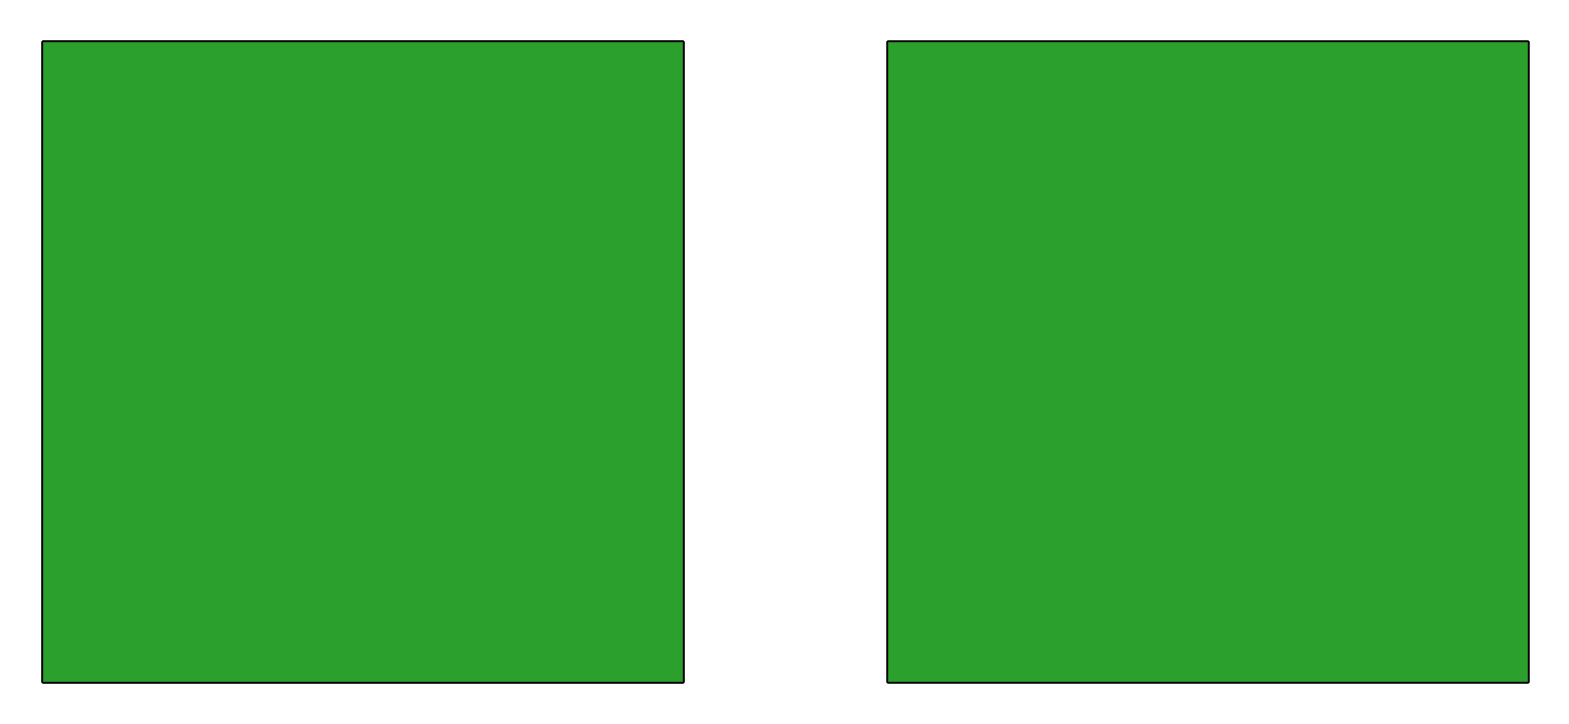

In [54]:
import matplotlib.pyplot as plt
from LayoutGKN.utils import load_image_rplan
from LayoutGKN.plot import draw_rooms
from LayoutGKN.constants import ROOM_COLORS

n, fs = 2, 10
fig, axs = plt.subplots(1,n,figsize=(n*fs,fs)); axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.set_aspect('equal'); ax.axis('off')
    img = load_image_rplan(ids[i], cfg.path_rplan)
    polygons, categories = extract_rooms_from_image(img)
    print(polygons)
    colors = [ROOM_COLORS[cat] for cat in categories]
    draw_rooms(ax, polygons, colors)